In [1]:
from helpers import *

def od_xml_to_df(file_path):

    tree = ET.parse(file_path)
    root = tree.getroot()
    gt_od_df =  xml2df_str(root, 'tazRelation')
    
    gt_od_vals = gt_od_df['count'].astype(float)
    print('total GT demand: ',gt_od_vals.sum())

    return gt_od_df

In [2]:
base_path = '/Users/rodrse/Downloads/ForSergio_nov26_2023_final'

In [3]:

taz2edge_xml = 'taz_new.xml'
net_xml = 'SFO.net.xml'
fixed_routes_xml = f'{base_path}/5hr_route_choice_set.csv'
od_duration_seconds = 5*60 

# duration of sample time for simulation output statistics
simulation_stat_freq_sec = od_duration_seconds
sim_end_time = od_duration_seconds
additional_xml = f'additional.add_statfreq{od_duration_seconds}.xml'

# suffix of simulation output edge file
EDGE_OUT_STR = 'edge_data_SFO.xml'
TRIPS2ODS_OUT_STR = 'trips.xml'
SUMO_PATH = '/usr/local/opt/sumo/share/sumo'

In [4]:
gt_version_str = 'v4'

# gt v4:
mean_od_val = 100
num_ods = 10

print('if you want to optimize them all (~86k) set num_ods as defined in commented line below')
#num_ods = routes_df.shape[0]

if you want to optimize them all (~86k) set num_ods as defined in commented line below


In [5]:
od_xml = f'gt_od_{gt_version_str}.xml'
file_gt = f'{base_path}/gt_od_{gt_version_str}.xml'
file_gt_edges = f'{base_path}/gt_edges_{gt_version_str}.csv'
prefix_output_gt = f'gt_{gt_version_str}'

In [6]:
# Get GT OD
print("Reading:",file_gt)
tree = ET.parse(file_gt)
root = tree.getroot()
gt_od_df =  xml2df_str(root, 'tazRelation')

gt_od_df.head()

Reading: /Users/rodrse/Downloads/ForSergio_nov26_2023_final/gt_od_v4.xml


,from,to,count,data
0,10100,10400,97.4,None
1,10100,10500,114.9,None
2,10100,105000,104.1,None
3,10100,108100,100.0,None
4,10100,108200,109.1,None


In [7]:
print("Reading:",fixed_routes_xml)
routes_df = pd.read_csv(fixed_routes_xml, index_col=0)

Reading: /Users/rodrse/Downloads/ForSergio_nov26_2023_final/5hr_route_choice_set.csv


In [8]:
gt_od_df = od_xml_to_df(file_gt)

total GT demand:  1044.3999999999999


In [9]:
gt_od_df.columns

Index(['from', 'to', 'count', 'data'], dtype='object')

## High-Dimensional sample-efficient Bayesian Optimization 

Source: https://botorch.org/tutorials/saasbo

### Declare parameter space

In [10]:
import torch

device = torch.device("cuda:3" if torch.cuda.is_available() else "cpu")
dtype = torch.double

### Declare search space
# dimensionality of input space

dim_od = gt_od_df.shape[0]

bounds = torch.tensor([
    [ gt_od_df['count'].astype(float).min() - 2 for _ in range(dim_od)],
    [ gt_od_df['count'].astype(float).max() + 2 for _ in range(dim_od)]
], device=device, dtype=dtype) 

bounds



tensor([[ 85.8000,  85.8000,  85.8000,  85.8000,  85.8000,  85.8000,  85.8000,
          85.8000,  85.8000,  85.8000],
        [116.9000, 116.9000, 116.9000, 116.9000, 116.9000, 116.9000, 116.9000,
         116.9000, 116.9000, 116.9000]], dtype=torch.float64)

Read output of GT simulation

In [11]:

sim_edge_out_gt = f'{base_path}/{prefix_output_gt}_{EDGE_OUT_STR}'
df_edge_gt, _, _ = parse_loop_data_xml_to_pandas(base_path, sim_edge_out_gt, prefix_output_gt,SUMO_PATH)
# picking at edges as GT edges
num_gt_edges = df_edge_gt.shape[0]
print("Number of GT edges:",num_gt_edges)
gt_edge_data = df_edge_gt\
    .sort_values(by=['interval_nVehContrib'], ascending=False)\
    .iloc[:num_gt_edges]

#gt_edge_data.shape




Number of GT edges: 197


#### Bayesian optimization helpers

In [12]:
from botorch import fit_fully_bayesian_model_nuts
from botorch.acquisition import qExpectedImprovement
from botorch.models.fully_bayesian import SaasFullyBayesianSingleTaskGP
from botorch.models.transforms import Standardize
from botorch.models.transforms import Standardize
from botorch.utils.transforms import normalize


In [13]:
WARMUP_STEPS = 32
NUM_SAMPLES = 16
THINNING = 16

In [14]:
from botorch.optim import optimize_acqf
from botorch.utils.transforms import unnormalize


def optimize_acqf_and_get_observation(acq_func,bounds):
    """Optimizes the acquisition function, and returns a new candidate."""
    
    dim = acq_func.model.train_inputs[0].size(dim=1)

    # optimize
    candidates, _ = optimize_acqf(
        acq_function=acq_func,
        bounds=torch.tensor([[0.0] * dim, [1.0] * dim], device=device, dtype=dtype),
        q=BATCH_SIZE,
        num_restarts=NUM_RESTARTS,
        raw_samples=RAW_SAMPLES,  # used for intialization heuristic
    )

    # observe new values 
    new_x = candidates.detach()
    
    return unnormalize(new_x, bounds)

In [15]:
n0=25
df_0 = pd.read_csv(base_path + f"/initial_search/data_set_ods_{n0}.csv")

In [16]:

NITER = 10
BATCH_SIZE = 1 
NUM_RESTARTS = 10
RAW_SAMPLES = 1024
    

In [17]:
#/Users/rodrse/Downloads/ForSergio_nov26_2023_final/bayesian_optimization/vanilla_bo
### Run loop
dim=dim_od


# Data frame of current training data
df_training = df_0
df_training["bo_iteration"] = 0

#num_epsilon_iter = 2
bayes_opt_method = "bayesian_optimization/trust_region_bo"
ods_epsilon = []
loss_all = []
batch_data_i = []


In [18]:

# Base OD which we will update their count entries
base_od = gt_od_df.copy()
gt_od_vals = gt_od_df['count'].astype(float).to_numpy()

best_value = []
for i in range(NITER):

    file_od_epsilon_xml = f'{bayes_opt_method}/gt_od_{gt_version_str}_{i}.xml'
    prefix_output = f'{bayes_opt_method}/bayesOpt_{i}'


    ########
    # Start BO step
    ########

    print(f"########### BO iteration={i+1} ###########")

    # Obtain sampling locations x
    train_X = torch.from_numpy(
        df_training[[col for col in df_training.columns if "x" in col]].values
    )    

    # Normalize
    train_X_norm = normalize(train_X,bounds)

    # Obtain reponse data
    train_Y = -torch.from_numpy(df_training[["loss"]].values) # Take negative

    ###
    #Obtain next sampling location given current training data
    ###

    # best value so far
    best_y = train_Y.max()
    best_value.append(best_y)
    print(f"##### best_value={best_y} #####")

    # Declare model with newest data
    gp = SaasFullyBayesianSingleTaskGP(
        train_X=train_X_norm,
        train_Y=train_Y,
        outcome_transform=Standardize(m=1),
    )

    # Fit model
    print("Fitting GP model...")
    fit_fully_bayesian_model_nuts(
        gp,
        warmup_steps=WARMUP_STEPS,
        num_samples=NUM_SAMPLES,
        thinning=THINNING,
        disable_progbar=True,
    )

    # Computing the median lengthscales over the MCMC dimensions 
    # makes it clear that the first feature has the smallest lengthscale
    print("Median lengthscales over the MCMC dimensions")
    print(gp.median_lengthscale.detach())    

    # Construct acquistion function 
    EI = qExpectedImprovement(model=gp, best_f=best_y)
    
    # Maximize acquisition function to get next observation
    print("Optimizing acquisition function...")
    x_i = optimize_acqf_and_get_observation(acq_func=EI,bounds=bounds)
    x_i = x_i.cpu().detach().numpy()

    ########
    # End BO step
    ########    


    # Sample simulator (inner loop across all sampling locations within a batch)
    # TODO: Parallelize
    batch_data_i = []
    for j in range(BATCH_SIZE):
        loss_all = []
        print(f"########### Sampling location={j+1} ###########")

        # Generate OD
        #curr_od = gt_od_vals.copy()
        curr_od = x_i[j]

        print(f'total expected GT demand: {np.sum(curr_od)}')

        base_od['count'] = curr_od
        # round to 1 decimal point
        base_od['count'] = [round(elem, 1) for elem in base_od['count']]     
        base_od = base_od.rename(columns={'fromTaz':'from', 'toTaz':'to'})        
        create_taz_xml(file_od_epsilon_xml, base_od, od_duration_seconds, base_path)

        # simulate gt od
        simulate_od(file_od_epsilon_xml, 
                    prefix_output, 
                    base_path, 
                    net_xml, 
                    taz2edge_xml, 
                    additional_xml, 
                    routes_df,
                    sim_end_time,
                    TRIPS2ODS_OUT_STR)

        ## Compute loss
        sim_edge_out = f'{base_path}/{prefix_output}_{EDGE_OUT_STR}'
        print(sim_edge_out)
        curr_loop_stats, _, _ = parse_loop_data_xml_to_pandas(base_path, sim_edge_out,prefix_output,SUMO_PATH)
        curr_loss = compute_nrmse_counts_all_edges(gt_edge_data, curr_loop_stats)

        loss_all.append(curr_loss)
        print(f"############## loss: {curr_loss} ##############")

        # Parse training data
        df_j = pd.DataFrame(x_i[j].reshape(1,dim_od),
                            columns = [f"x_{i+1}" for i in range(dim_od)])
        df_j['loss'] = curr_loss
        batch_data_i.append(df_j)

    df_i = pd.concat(batch_data_i)
    df_i["bo_iteration"] = i+1

    df_training = pd.concat([df_training,df_i])


########### BO iteration=1 ###########
##### best_value=-0.0611600581652825 #####
Fitting GP model...
Median lengthscales over the MCMC dimensions
tensor([ 2.5411,  1.7869,  4.2342, 17.3874,  6.5617,  7.2392,  6.4277, 13.2873,
         1.0948,  4.5273], dtype=torch.float64)
Optimizing acquisition function...
########### Sampling location=1 ###########
total expected GT demand: 1066.3759688150296
Created  /Users/rodrse/Downloads/ForSergio_nov26_2023_final/bayesian_optimization/trust_region_bo/gt_od_v4_0.xml
od2trips  --spread.uniform --taz-files /Users/rodrse/Downloads/ForSergio_nov26_2023_final/taz_new.xml --tazrelation-files /Users/rodrse/Downloads/ForSergio_nov26_2023_final/bayesian_optimization/trust_region_bo/gt_od_v4_0.xml -o /Users/rodrse/Downloads/ForSergio_nov26_2023_final/bayesian_optimization/trust_region_bo/bayesOpt_0_trips_beforeRteUpdates.xml
Success.time 298.26
###### Running SUMO #######
Seed 0
sumo --output-prefix bayesian_optimization/trust_region_bo/bayesOpt_0_ --igno

In [27]:
df_training.shape

(225, 12)

In [28]:
print(base_path + f"/{bayes_opt_method}/data_set_bayes_opt.csv")
df_training.to_csv(base_path + f"/{bayes_opt_method}/data_set_bayes_opt.csv",index=None)

/Users/rodrse/Downloads/ForSergio_nov26_2023_final/bayesian_optimization/trust_region_bo/data_set_bayes_opt.csv


In [29]:
df_training = pd.read_csv(base_path + f"/{bayes_opt_method}/data_set_bayes_opt.csv")

## plot trajectories

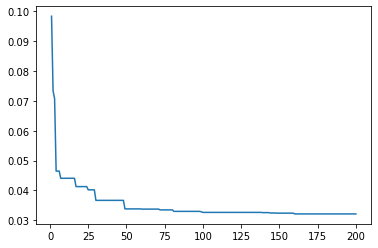

In [30]:
df_plot = df_training.query('bo_iteration>0')
import numpy as np
import matplotlib.pyplot as plt

x = df_plot['bo_iteration']
y = df_plot['loss'].cummin()

plt.plot(x, y)
#plt.legend(title='Parameter where:')
plt.show()

number of GT edges: 196
number of GT edges: 196
number of GT edges: 196
number of GT edges: 196
number of GT edges: 196
number of GT edges: 196
number of GT edges: 196
number of GT edges: 196
number of GT edges: 196
number of GT edges: 196


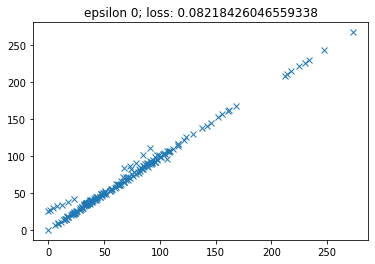

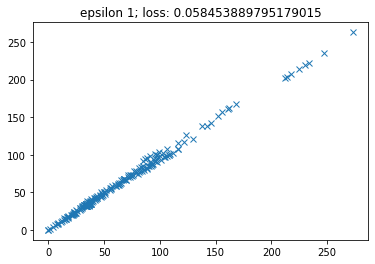

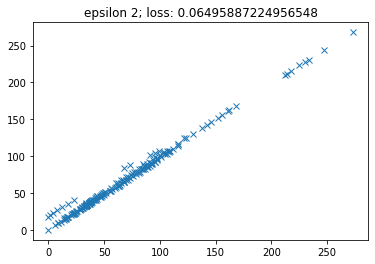

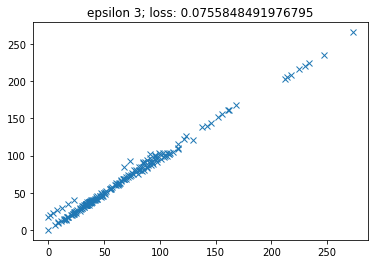

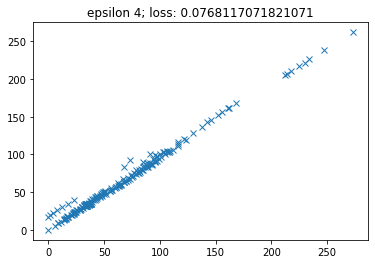

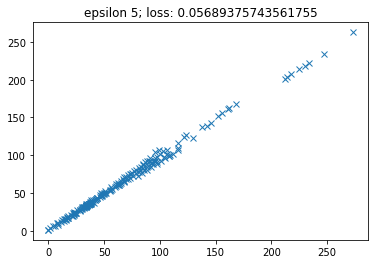

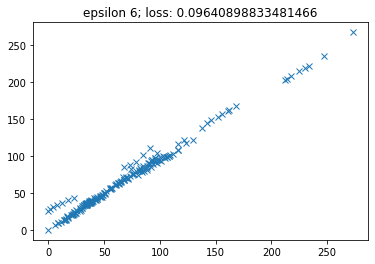

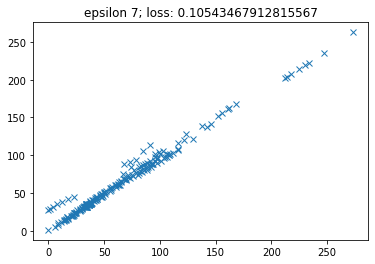

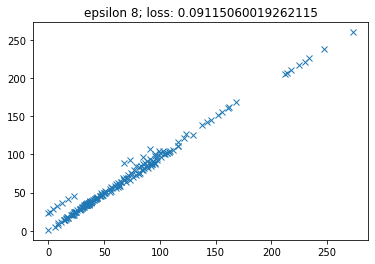

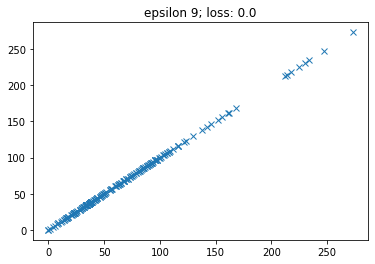

In [39]:
import matplotlib.pyplot as plt

for o1 in range(num_epsilon_iter):
    df1b = gt_edge_data.merge(edge_epsilon_all[o1], on=['edge_id'], how='left')
    curr_loss = compute_nrmse_counts_all_edges(gt_edge_data, edge_epsilon_all[o1])

    plt.figure()
    plt.plot(df1b.interval_nVehContrib_x, df1b.interval_nVehContrib_y, 'x') 
    plt.title(f'epsilon {o1}; loss: {curr_loss}')
